In [ ]:
import os
import urllib.request
import tarfile
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras.utils import img_to_array

import tensorflow as tf

In [ ]:
# Download DeepLab_v3 with xception backbone, pretrained on coco_voc train+val

tar_name = 'deeplab_model.tar.gz'
model_dir = 'model/'
tf.io.gfile.makedirs(model_dir)   # make sure the directory exist

# Downlaoding model
download_path = os.path.join(model_dir, tar_name)
model_url = 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz'
urllib.request.urlretrieve(model_url, download_path)

('model/deeplab_model.tar.gz', <http.client.HTTPMessage at 0x7a78ea2e5720>)

In [ ]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_HEIGHT = 256
  INPUT_WIDTH = 256
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break
    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image."""
    # Resize image with padding so it's not deform the image
    h = self.INPUT_HEIGHT
    w = self.INPUT_WIDTH
    resized_image = tf.image.resize_with_pad(image, target_height=h, target_width=w)
    # Convert image to array
    image_array = img_to_array(resized_image)
    # Run the model
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [image_array]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

In [ ]:
# Instantiate the model
MODEL = DeepLabModel(download_path)

In [ ]:
# Load input image
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgVFRUYGRgZGhgYGBgYGBgYGBgYGBgaGRgYGBgcIS4lHB4rJBgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISHjEkJCw0NjQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAK0BIwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAADAQIEBQcABgj/xABDEAACAQICBgYIAggFBQEAAAABAgADEQQhBRIxQVFxBiJhgZGxBxcyU6GjwdITUhRCVHKTstHwYoKSouEjc4PC8TP/xAAYAQADAQEAAAAAAAAAAAAAAAAAAgMBBP/EACARAAMBAAICAwEBAAAAAAAAAAABAhEhMQMSIjJBURP/2gAMAwEAAhEDEQA/ANCiFpzGBZppUJeOUwCtCo0AB4odQykXF0yxQOpf8oYXlP030+9/0agesfbIve52Jls/55ylXouVGuKhDjPIAWPOJXkUvCk+KqWmi4EZGSbTyPQfSrPr0KjXdSbX29XIiewjp6tJtY8BPI7mSXkZ4AWujz1B3+ckFpDwB6g7/OH1oGBYsGhnn+mun/0WgNQ2eodRD+UD2m55gDtMG8WglvBZaVxdNAA7op4MwBtxsZEp1UcXRgw4qQfKY3jNZ3uxLM18zc37S09V0GwjoyPr2RtZXS1wxANiDfjbPnEXkWlP83hpmGHVhGjMJ7PfHvKExKLZnlCF4GltPKdeYBIVpC01jUo0mqVG1VBHMk7ABvMkUzMr9I+lXqYk0BklMdUcXKgs3+6wmVWIaZ1lpU6f0VJvSqW49XynpujXSChiQRTfrbSjZOO7eO0ZTE6aM1wwuBfle+0+M9p0A0Y9PF03dSmsjZ2yJKkqB3X8Iit7jHccajViICpJJkeoJUkGDZDkIxnnMchygWmASA8oukumKeGUu57FUe0xtulsjTKfSQ71cUyXyQKij/KGJ8WHhFqsQ0zrJXrFYuLUF1e1ze3O0950c6Q0cYhKEh1tro1tZe3tXtmGforL7WQzz4f3nLfoNUqDG0/w1Ztz6t76hyb6GKqejOUbqRAPJG6BdZUmRnMExhnECRMNGzo606AB3ECwkl1gHWAAgIamIxRDIsAMw0Too/pNcVCTUSowFxltDK4O+4a8s3ZzamHzBN73ubW22PbxnodN6KT8RcStxUC/hmxydDmAw4g3se2eeN9YEUiO0ggDic8vCc1rKO3xUnAzonoofp1WrckKoPYHcapB4nJj/mnvTPP9FdBjD67mo7vUOs9z1ASSQFXgL2zv3T0LS8LEclPa0E4kd1khoBzHFJuCHUHf5wwEZgR1BzPmYYCYYKizOfSnSYVKLsLpqEDgrqxJ8dZfDsmkosq+lGhVxWHamzapBDq1r2ZQdo4EEjvmUtRsvGeI6O6JwzgVF691tqkhgCRcm21TtFjwlq+GFN1AFl6oRFyF9a5sOJ2SZgtG06FNUpIFIzvvY22sd8G4d3Q/hGystycgLN1s757PhObG3wd3skuT02E9mEcRmG2QrTrOAAgzikRV2mOtMARBM59KGEVaiVADrOtj1eqStgLN+YgbNvV7ZparImmcPTekVqIri4KhgDZhsI7RFpcDQ/kZV0SwNf8AE1vwmNP87WVbZ7z7W3YJ7OojF6RSwfWVQ24cSRw7JOrvZBq2FtgGVu6OwOjCXSozkap19QADPPIm+zORUunwdLpTPJfGCcQrGBqNOk5EPYZDlAMJJOwchAsJgDEEzr0k6Jdan6ShJVwFcflcABSOFwJpSLIuklUgqyhrj2SAR4RaXA09mD4ak79XVcm+wjPeLZbRsmhejXRNSlWd6iBCUuq7WAuAQ3DM3npkpKl9VFBy2ADYOyTNCYQDWq3Os/VINrKFO7tOUlLbotaSkszGNHkwLtOg5gbiRyIZzBGYaJadOvOgaSGMC5ilojQAaDEfEhe08BEJjTllviVWDzOkLFVy5FwQozttz5wGKprq3BEnNSgv0cZyffZeWksQHR+OtkwOQ2j6iWaVlbMG/wBOY3SqNHVNxH0a/WB49U/T4x5p9MlUrtFgzQDmEaDaUJFngfYHf5w0DgfYHf5wzTTB4cDMysx+LZjbVIT4nn2dknWvygK63NpKq/CkJdkCs+V7HnthcI4ZRY5jbzj61LKV+GbUY8N/9ZkvGUte0l7ho9zB4aLUMscwiHM8oVYGltPKFEDQySrxILtty3dg498nq8BhQLSd/wAH8fGsq8ThNUbTLLAVNYX37+cj497ECdhG1Xtubz3RZePB7WzpYVGgGMe5gzLESQDkOQjTFXYOUa5mACrVm2L3n+kDqbzmdpJih8yu/b4x7LkeUg606JlSBSneKaBU3UkcsvGGojKPNQXAO/ZMNY2jWJuG2jfxEcxjai2cEb8o4iWl6iFLGDaNMe0GYwok6dOmmjohi2iEwAYdoHfKp67HE9X2FQqx4uSCo8AfGTXr7be0bAd+yNaiFAA45niTtMhXy5Lz8eA9G7KCw1Sdove3fOFPfH09kcqTEa2QccNUCwvnY57BxlPgK5bXByZWbLsvdT4WlxpFpAxmH1GSsN6qj9uXVb6d4hm8hucForBgCN+cRoLAuNUrfZmORz87wzCWl6tIUseFhgfZHf5w5gMD7A7/ADhmawJmiiK22VC1S2JChskRrj/EStvAD4ye9UAAbzsEp8BSKYmoCb3FwewkGQrk6JWF5iSdU6q6zbhe1++VdVOtnvEt5BxaZ3gwRK0d7A/vlCPB6PPVtwJhakuujnr7MHR290MYKjtMKZoDAc5HoNtHP4GSJX4dyHdTtBy7Qdnl8ZK/wp4/0dX9rOArgZX/AFSGHMZwtYEknhBOcpPSxZWvOKxMMeqvIQrzoOVjlGQgq5y5mGAyEh4ypYjkYtPEPC2iA9RmxHV9kIdfuI1bduZ+MsKRvAYFRq629ib9xIt/fGHw+RIknOLSvtraOBtylZpzF/hKlTaFqAt+6QVb4H4S3G0iUfSdL0mivoaeWW7uHUMpvsYH4iFBuARvznnujFRhQXWvbWZV5Cx+p8JdYWp+r4fUSkVzglzxqCtBwjRksQGTo6dABTAYh7C3GHY5SuxtWxPHJQOJP/0RKeIpK1jcMmtUJ3L5nIfC8l1x1e8ecTDUdRQN+0niTtgsfikphS7qoZ1QFiACxuQL8TaYpyQdbQemx2QpfKAD5xBV9q4yGzPblJJlWiHizrEDibeJknSFHXpOg2kZc1zHxAlZjsciAO7BVVgSSbD2hLsmUhamTt40U2BexQ7j1T37PjaWLmVeJXULqNx115Xv8CDLNjNjjUZfOMssF7A7/OPrDqmDwZ6g7/OEqbI1dCT2RVQfijsU2+Ercc5GJW35QD3ydWxKU3ao7BUSm7Mx2BRa5njaXTPC1q2uW/DzAAqdXIZA63s57bXykWvjx/S0te3P8PehspExTXFz3R9LFI6BkZWB3qQw8RI2OqbFUXbOw42F5gxY4D2R2wtQyk6NaSR1KKwJXrZZ5HaL9h85cO0vPRz0soSkczDGBpHOFMYwbfORq7Lr7riwbs3i/cb98jdIdJjDYepXIuUXqg7C7HVQHsuRfsvMRw3SnE06r1lqtrubvrdZX4ayncNgtawyFotTqGmvV6btibCzbth5GRaqZ6o2k2kTo9phMZhlqLYEjVdfyOPaX6jsIi6N0hr4l6DI4amivrG2o4bqqVN73vfIj9UyPrrwt7YtLsLawG7KcTHvAlp0HOSlOQkHSAyB5yYhyHIQOMF0bsF/CLS1DS8ZD0W16Y/ebzMl0xmZ5zo3phGZ6LdU/iHULZB77VW+8W775TL9NdJcScTWZK9VB+I4VUquEAViqgKDbYBFa9pxGt+rem6PtkbSmGDoynhlMRp9MscuzE1O/Vf+ZTJaekLHAWLo379Nf/W0T/NjLyyat0ewxOG1D7Su/iD/AEku1xcbR9J5z0YdIWxNOutTV10qB+qCo1HUAZEnejeInqMUliWGz9Yf+w+sZzwmE3ra/ByvrAHj57xEMjYepZyu5sxzG0f3wkho8vUJSx4NnRLzowo4nKQVQGoCTsDMB/iy8hJd8pX4FXZy5A1RcDjfVX+rRK7RSfq2WTGZv6XMQbYanuJqOeahVX+Zpo7GZb6XKgNXDrvCOTyZ1A/lMcm+jzmjOlmKoAKtUso2K/XA5E9YcgZZP6QcQQbLTBO/Vc/DXnjSYsVyjFdL9J2ldMVsQf8AquWG5dijkoyv27Zumg8QXw1BztelTY82RSZ89M0+g9CU9XDUFG6lTHgixksBNt8jdKA9QgXuWU5gdUjM+IHjC4SoWRSQRkMjt2dki6YBspHG1/3mWw75JwzdRP3R5RF9mVpfFMucGeoO/wA4VswR2QGDPUHf5yQDGJnh/SaG/QyVJA10DW3qWGR/zBT3TGqk+i9K4BMRSei4ujZHcewg7iJiHSzo+2EcLra6Praj2tfVNircGHx+ASX+D+SX9iow2KdM0dkPFGZD4qZ7b0a6Vd8aFq1He9Nwmu7N1gUbIMduqreBngBPWejXDl8dTIOqaavUNs7jVKW7M3HhHwlrPZYfSBw2Ja+aF2U23jWIyHdPea1wCNhAI5Gefxug2dk1bWVVQMTsAWoSx7S7DZwnonizLRbyOaxo6jth5HonOHjkzzHpGwjPgKhX9QrUI4qnteAJb/LMHc5z6feirqyMAVYFWB2EMLEHuM+fOmPR9sFiGpE3pm7U2/MnA/4lvY+O+ArD9CekZwda7E/hPZag4flcDiN/YTwE2ujqBxVFiGW2txU2YG/D+s+a9a03foXjFfA4exvqoEbsKdUj4SdcclfH8viet2iAYSFgHfWIUqUuLgkgrcbR8cpOcRperTKn1eB02DkIjGcuwcohjCmZYjVTG1ErDqBixzIyIsrAjZYlTMzZyTdjmczzOZn0DpTQFKvUWq2sHFgbWIdLEFGBByIJB32nz7i01HdPysy5/wCEkZ+ESVmj+WvbDjGMYym9x9d0WOSPf+h2sRjKqDY1Biea1Keqf9zeM16pMZ9ELWxzD81CoB/rpt9Js1SAIrcQlr2/VAdew32f3xkhXDAEbDnAaSYKhY7gfA7vgI3RhJpr/mty1jJzxTRalspkm86dOlCYxTlI2jqTIrBvzsRyytbwh6ZyjgZjXOjJ8YOM8f006JLi2SqtQo4AQ3GshUEkZXBBuTmPCeuvA4wdQ9ljB9Akm+TK/V24N3xC2H5FYsfEgD4yZQ6DYduqWqKSAwYMt7G4zBFjmJ7TENcQYSzJ/wBtfMn6yXtRb0lcYeLq+jdFN/0hiv5fwwG/1a9vhNLw1AIiIt7IqoL5mygAX8JXjruqjjc8hnLaPLb7JVKl8FVpeizhNUE2ccLLf9c8sx/mvukpVsAOAA8Id4Exs50x1xhZYP2B3+ckCRsH7I7/ADhxNFKzE4orUZOR8Rf6GeI01oDHP+OtL8CpQquzhKhOtTYixZCRZWyvtI7Ns9/pDAB+uLBxYkm9iqhsrcmPwkeiCq5nM5nsNgDaRac0dGqpwynQ/QqulZGxC0/wwbspYNrZEAaoFjnbbNO0NhUQsUREFgOqoW9z2DskbFvdgJb4NNVAN5zPfGlumJUqZxEtTlEJijZGMZRkR1Hb3Q4kakc5IWBoZZ4/pL0co41z+LrgoWCsjAEBrawsQQfZG0bp7CVLjrvz8xEp4h/Gk20zN8R6O8Ot/wDq1rA8U+2eo6O6DTD0Cqa5U673ZiesAqnZYDIGWWJUWPaZZ4WnqIq8Bn9Ysp12O2o5RC0YpDkqOr1lYjZcapUnmCPCWTmP2bIJzKSs4J1Xs9JC7ByEaYgOQ5CdeaKcxlW+BpMxdqSM1/aZFLeJF5ZGQmOZ5mTvopHZ5bTWiaGJxK0aidUUyQVOqVbWFiCOy/ZIfqxwwNzWr24Xp+epLiil8W7blpqP9TD/AJl5Vfq90RNopUy/wrOinRrDYdnelT646odmLvY3vYnJb5bAJ6OpI2iUtTuf1iW+g8pJqS09EKzeCJicOrqVa9uw27PrHBQAABYDIDgBHkTiJob+A50WdAwiUamZHZf4iF1oH8MgXtu2bYD8V7+wbd4gaTNaMrtdG5HykY1H/IYlZ21GJBG7ZxNpj6NXZW1msp47P/kk4trOg3apA7pAdSaiDcWHjfL4yZpVXGrcWNyRfuv5iRS4Z0Nr2SCaKe9RzwAA7zn5S3JnntGI4cjaSpPgR/WXCs49pT3SkfUj5fsPcwLGK7fvd4gX1twjiFrgHunIySGldhCwQEjj5wiYg71PjAwnueq3I+Up3OQkytXOqRnnln2ytxVbVF+El5Oy/iXBUVXJewzJytPVhrTzmjE1qgIFzmeO7b8RL06/5T4TfEuGxfNS1IlB4x2kcs9vZbwMYax3qw7pUkS6TZySjStpMWPVNuYI+klpTc7WH990wCU1SUy1NZ2bifhuk/EUyEYkjYZVYcZE9/hJ+RlfEu2Ij3qKu4EnwBIlmr9srtHYbXZ3va1gMt5zP08ZYfov+I+E2OhfL2F/EEG7wbUANjnwjSD+b/bHEJobIchEvIJxNsrHLLdOXE33GBpOvIDt1jJGvlf4SBWNk1t+Zk76H8a5BYFM6z22si37FF/NoWuer4x2HpMKQyOY1ie09a8HVB1O6/nFpZhSXrZd0hZQBuAHgIjmR6TvYXU7N0Ix7GljnGEziYxgYmq3EeMAF1osHqtxXxP9J0DRfw4NlkjWjWMABKIDGodRuV/DP6Qr3EVXDCxEzAPOOevT/eX+YSx06LFG/eXxAI8jIDUytRFP6tQfA5fC0stNdZE/fH8rSaXDLN8ojaJF3ZuCW/1H/iWjvK7RS2Vj+ZvgMvO8ltUtGnonX2OYwRWFUX2x+qIwpNwC2Qd/nJJWR8L7A7/OSEqQAi49jqDP9b6GUWk2JWX+kUuhI3WM85Xuxt2GTpclvG+Cd0YS5d+AAHebn+WX7N/d5UdHyFR/3h5Sc9a8aOid/Y6o8FHLCACMKNornJKtBL2RCTAA9ddZGHFSPhKLWsndLlKm6eedzqcvpJ2V8f6W2hR1GPFz8ABJdR5FwL6tJBxF/wDVn9YUA7THnonXLZ1iY1spzVOEGAZphK1chyE4QqjIchBMYAOLGx5GUuIqXQ57pb60oNIoQrAdsSinjLlGIw6/9tR4gD6yBiX6hlniVtSI4KP9tj9JS4h7rbjYeOUykND7Lum1kX90eUYzXna14oAlCI3UjWjncQN7wAS86OsP7E6ABiJ0WcZoDCIF6e8SQYOq4VSTuF4AU+Otr628AE8wf+BBYnFAtqcyPD/mMxjkqzeXCSKuAumta7ixHG3CSWvcLPFmjsE90VRuyPO+cnpSA7ec86mLCPdTsOa8e7xnowf74c40tNCXLTFKQZEIIhJjiE7BDqDv84RqfCJgvYHf5w0AIzG4KneCPGee1CpuRuK5duzyno8UhKmwztl2yoKXBvl5jukrK+L9KfC4x0a1mXjrKbHnlLWnpGx64BX8y5w2FcX63juMnPhkO1FPMCbKecMKa3lBVttGycV7PD+k4RDKEh1Fczyj3pxKJzhYAQKraoJ4AmUdYkpcZ33z0tdLiVDkHIW4GSsr4yGjVtVSofYLZgC3eZPwT1mBFQDdY5XPG9jAEFPZOXDbJFLSQFgyncOrntNtkJa/ptJvhJE1KdtseQOPj/WLeJKkQ6jIRrpePQZDlOMAIbraVGl1NjbYbeN7fSehZLyi0lVCkrvFsuN9lhJ30P4+zn08hBTVbWIsdlgSLce0+ETDprVEXcOse7Z8bSt0foxkdqlTa19VdyqeP+KTmdqbApa5BBuL5Ej+kVtp8jpLGkXpUAbJHd75CVKYqqXGs1werq5Dadotvl4i22eBlJek3LkjrTMfqgboUnsjWHOMKM7vjOi2nQAcZ0yrFekWooypH2UP/wCrbWBJPs9nxkT1m1fcn+K32zNF9jX4OrTDAqcwciJko9J1X3PzD9sf60X/AGcfxT9sND2NDGhgGB12Kg31SAe6/hulnqzKfWi/7OP4p+2d60X/AGcfxT9sxJLo1+Rvs0tNHU1bXCDW232+HCSDMs9aNT9nH8VvtnetF/2cfxT9s3Qd72alEImW+tF/2cfxT9sX1nv+zD+KfthpnsbFg/YHf5w0xlfSpUGQoW/8rfbF9a1X3HzW+2Gh7GxkSNiMKHz2Hjx5iZJ61avuPmt9sX1qVPcfNb7Zj5NV50aO+japy1kA4gm/hbl/eyzw9MqoVmLEfrGZL606nuPmt9sT1qVPcfNb7ZkpIH5fbtGv2iETIT6VKnuPmt9sT1p1PcfNb7Y2mexsVHbCmY0PSpU9x81vtnetOr7j5rfbDQ9jZDAvhkJuUBPGwv4zIfWnV9x81vtnetSp7j5rfbMD2NYfBIeI5H+sbTwKKb2ud1ze3IbJlPrUqe4+a32xPWpU9x81vtmcfw3/AEZr5jDMj9alT3HzW+2J606nuPmt9sbTPY2ddg5TrzGvWtV9x81vtieter7j5zfbDQ9jZS0Q37ZjfrXq+4+c32zvWvV9x85vthoexrONoF1y9rdfykOno5ybuwA4Lme8kTMvWpU9x81vtnetSp7j5rfbFaTes1eVpYjWKWFRcwM9hO0+MNaZD61KnuPmt9s71qVPcfNb7Y2mOtNdMYRMk9adT3HzW+2L61KnuPmt9sND2Na1eXxiTJvWpU9x81vtiw0PY//Z'
f = urllib.request.urlopen(url)
jpeg_str = f.read()
input_image = Image.open(BytesIO(jpeg_str))

# Run inference using DeepLab model
resized_image, seg_map = MODEL.run(input_image)
resized_image /= 255.

(256, 256)
(256, 256, 3)


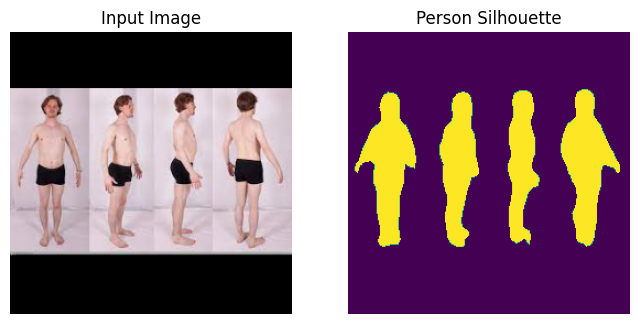

In [ ]:
# Create a binary mask for the person class (label 15)
person_mask = (seg_map == 15).astype(np.uint8)
rgb_person_mask = np.stack([person_mask, person_mask, person_mask], axis=-1)
print(person_mask.shape)
print(rgb_person_mask.shape)

# Visualize the result
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(resized_image)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(person_mask)
plt.title('Person Silhouette')
plt.axis('off')

plt.show()